## Selecting top-K NMF factors

Please keep all required files in the same folder as this notebook or edit paths appropriately!

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Load masks for brain areas and cortical layers

In [2]:
mask_0259 = np.load('usual_order_annos_noTRN_0259.npy')
mask_0359 = np.load('usual_order_annos_noTRN_0359.npy')

In [3]:
ctx_mask_0259_full = mask_0259==1
ctx_mask_0359_full = mask_0359==1

In [4]:
ctx_info_0259 = np.load('final_ctx_reps_labels_with_positions_0259.npy')
ctx_info_0359 = np.load('final_ctx_reps_labels_with_positions_0359.npy')

In [5]:
layer_mask_0259 = np.load('ctx_layers_annos_0259.npy')
layer_mask_0359 = np.load('ctx_layers_annos_0359.npy')

#### Divide ctx into features and locations

In [6]:
def info2feats(info):
    return info[:,:-3], info[:,-3:-1], info[:,-1]

In [7]:
feats_ctx_0259, locs_ctx_0259, _ = info2feats(ctx_info_0259)
feats_ctx_0359, locs_ctx_0359, _ = info2feats(ctx_info_0359)

#### Load nmf representations and all locations

In [8]:
nmf_0259 = np.load('NNMF_15D_0259.npy')
nmf_0359 = np.load('NNMF_15D_0359.npy')

In [9]:
nmf_ctx_0259 = nmf_0259[:len(feats_ctx_0259),:]
nmf_ctx_0359 = nmf_0359[:len(feats_ctx_0359),:]

In [10]:
locs_0259 = np.load('locs_0259.npy')
locs_0359 = np.load('locs_0359.npy')

#### Convert to NMF stacks

In [11]:
def locPlots(reps,locs):
    stack = np.zeros((1420,5805,reps.shape[-1]))
    for ii in range(len(locs)):
        r,c = locs[ii].astype(int)
        stack[r,c] = reps[ii]
    return stack

In [12]:
full_stack_0259 = locPlots(nmf_0259,locs_0259)
full_stack_0359 = locPlots(nmf_0359,locs_0359)

In [13]:
ctx_stack_0259 = locPlots(nmf_ctx_0259,locs_ctx_0259)
ctx_stack_0359 = locPlots(nmf_ctx_0359,locs_ctx_0359)

#### Choose top K factors

Note: lower values of lamda encourage denser (i.e., non-localized) maps

In [14]:
## low lamda = denser maps

def topKChooser(stack,mask,k,lamda=0.5):
    fact_list = np.zeros(k)
    n_comps = len(np.unique(mask))-1
    n_facs = stack.shape[-1]
    total_pix = np.sum(mask>0)
    scores = np.zeros((n_facs,n_comps))
    for ii in range(n_facs):
        fac = stack[:,:,ii]
        for jj in range(n_comps):
            mask_bin = mask==jj+1
            mask_inv = 1-mask_bin
            area_pix = np.sum(mask_bin>0)/total_pix
            coverage_score = (np.sum((fac>0)*mask_bin))
            leakage_score = (lamda)*(np.sum((fac>0)*mask_inv))
            scores[ii,jj] = coverage_score - leakage_score
    for kk in range(k):
        mm = np.max(scores)
        f_no = np.where(scores==mm)[0][0]
        area_no = np.where(scores==mm)[1][0]
        scores[f_no,:] = -np.inf
        scores[:,area_no] = -np.inf
        fact_list[kk] = f_no
    return fact_list.astype(int)

#### Function to plot cortical factors

In [15]:
def score2ctxplot(stack,indices,th=1,cmap='magma'):
    facts = stack[:,:,indices]
    m1 = np.max(facts[:,4100:,0])
    m2 = np.max(facts[:,4100:,1])
    m3 = np.max(facts[:,4100:,2])
    ss = makeRGBplot(facts[:,:,0],facts[:,:,1],facts[:,:,2])
    ff = plt.figure(figsize=(16,5))
    plt.subplot(141)
    plt.imshow(np.flipud(ss[:,4100:,:].transpose(1,0,2)))
    plt.axis('off')
    plt.title('Combined RGB Plot')
    
    plt.subplot(142)
    plt.imshow(np.flipud(facts[:,4100:,0].T),cmap)
    plt.axis('off')
    plt.clim(0,m1*th)
    plt.title('Factor #'+str(indices[0]+1))
    
    plt.subplot(143)
    plt.imshow(np.flipud(facts[:,4100:,1].T),cmap)
    plt.axis('off')
    plt.clim(0,m2*th)
    plt.title('Factor #'+str(indices[1]+1))
    
    plt.subplot(144)
    plt.imshow(np.flipud(facts[:,4100:,2].T),cmap)
    plt.axis('off')
    plt.clim(0,m2*th)
    plt.title('Factor #'+str(indices[2]+1))
    return ff

#### Function to plot factors obtained on the full slice

In [16]:
def plot_full_factors(stack,idx,th=1,cmap='magma'):
    nn = len(idx)
    ff = plt.figure(figsize=(8,2.5*nn))
    for ii in range(nn):
        plt.subplot(nn,1,ii+1)
        plt.imshow(stack[:,:,idx[ii]],cmap)
        plt.axis('off')
        plt.title('Factor #'+str(idx[ii]+1))
        mm = np.max(stack[:,:,idx[ii]])
        plt.clim(0,th*mm)
    return ff

#### Function to make RGB plots

In [17]:
def makeRGBplot(rch,gch,bch):
    rn = (rch - np.min(rch))/(-np.min(rch)+np.max(rch))
    gn = (gch - np.min(gch))/(-np.min(gch)+np.max(gch))
    bn = (bch - np.min(bch))/(-np.min(bch)+np.max(bch))
    stacked = np.dstack((rn,gn,bn))
    return stacked

#### Cortical factors, slice 0259

In [18]:
idx_ctx_0259 = topKChooser(ctx_stack_0259,layer_mask_0259,3,0.3)

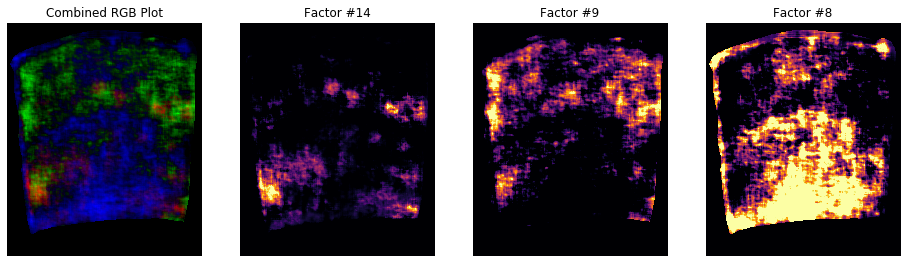

In [19]:
cmap='inferno'
ff = score2ctxplot(ctx_stack_0259,idx_ctx_0259,0.6,cmap=cmap)

#### Full image factors, slice 0259

In [20]:
idx_full_0259 = topKChooser(full_stack_0259,mask_0259,6,0.5)

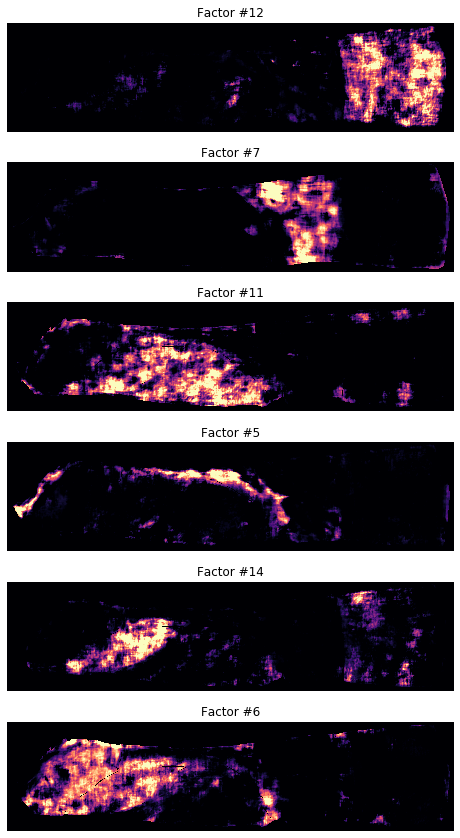

In [21]:
cmap='inferno'
f259f = plot_full_factors(full_stack_0259,idx_full_0259,0.5)

#### Full image factors, slice 0359

In [22]:
idx_full_0359 = topKChooser(full_stack_0359,mask_0359,6)

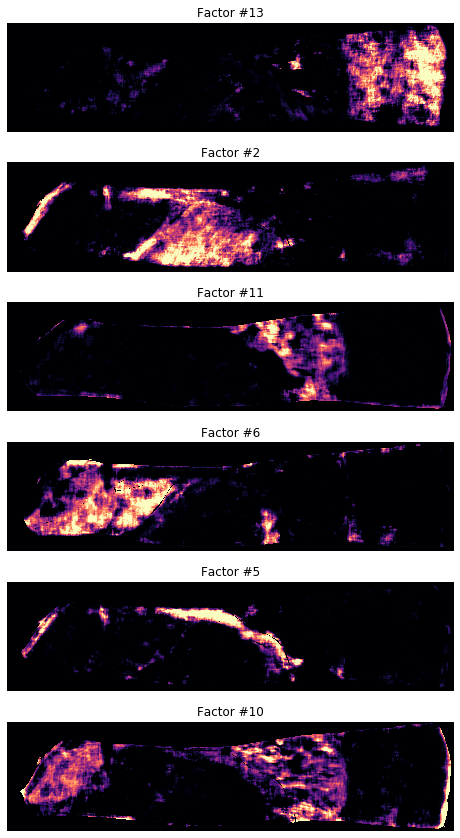

In [23]:
f359f = plot_full_factors(full_stack_0359,idx_full_0359,0.5)

#### Plot top-6 ctx factors for both 0259, 0359

In [24]:
idx_ctx_0259_6 = topKChooser(ctx_stack_0259,layer_mask_0259,6,0.3)
idx_ctx_0359_6 = topKChooser(ctx_stack_0359,layer_mask_0359,6,0.3)

In [25]:
def plot_ctx_factors(stack,idx,th=1,cmap='magma'):
    nn = len(idx)
    ff = plt.figure(figsize=(4*nn,5))
    for ii in range(nn):
        plt.subplot(1,nn,ii+1)
        plt.imshow(np.flipud(stack[:,4100:,idx[ii]].T),cmap)
        plt.axis('off')
        plt.title('Factor #'+str(idx[ii]+1))
        mm = np.max(stack[:,:,idx[ii]])
        plt.clim(0,th*mm)
    return ff

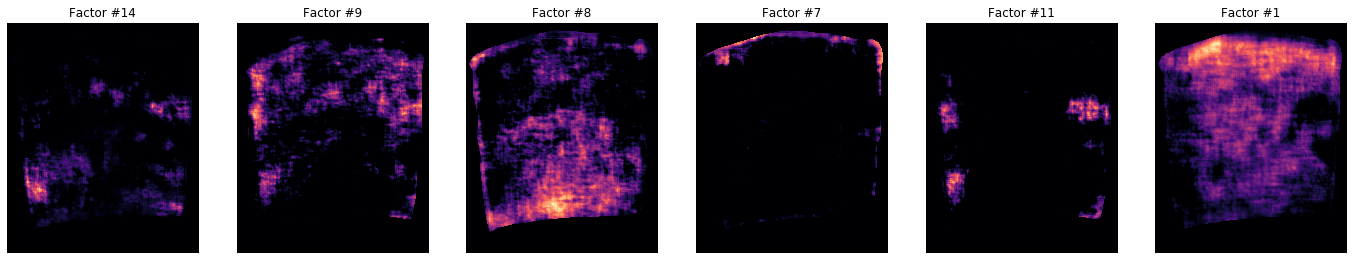

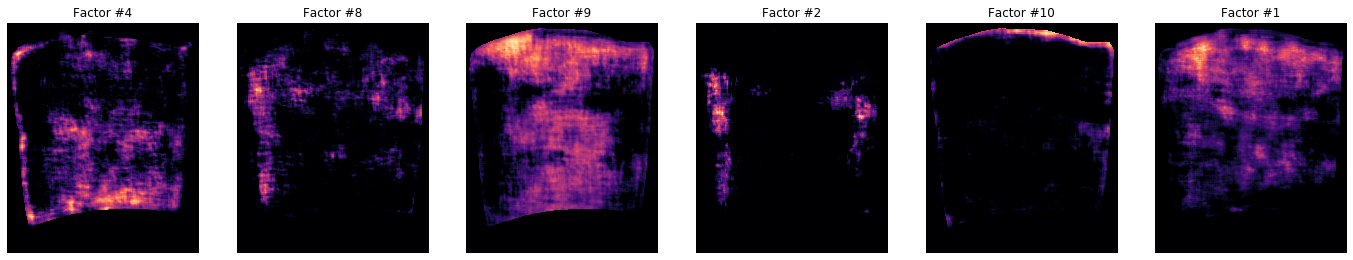

In [26]:
fc2 = plot_ctx_factors(ctx_stack_0259,idx_ctx_0259_6)
fc3 = plot_ctx_factors(ctx_stack_0359,idx_ctx_0359_6)

Text(0.5, 1.0, '0359 - Factor #1')

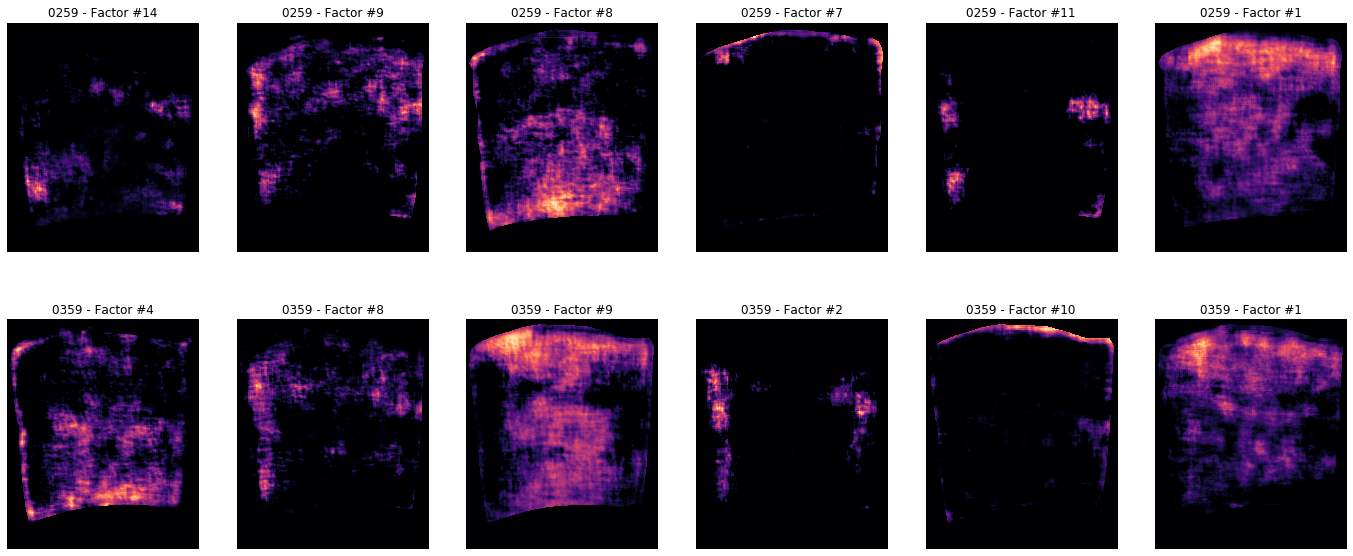

In [27]:
fc23 = plt.figure(figsize=(24,10))

plt.subplot(2,6,1)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[0]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[0]+1))

plt.subplot(2,6,2)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[1]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[1]+1))

plt.subplot(2,6,3)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[2]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[2]+1))

plt.subplot(2,6,4)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[3]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[3]+1))

plt.subplot(2,6,5)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[4]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[4]+1))

plt.subplot(2,6,6)
plt.imshow(np.flipud(ctx_stack_0259[:,4100:,idx_ctx_0259_6[5]].T),cmap='magma')
plt.axis('off')
plt.title('0259 - Factor #'+str(idx_ctx_0259_6[5]+1))

plt.subplot(2,6,7)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[0]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[0]+1))

plt.subplot(2,6,8)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[1]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[1]+1))

plt.subplot(2,6,9)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[2]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[2]+1))

plt.subplot(2,6,10)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[3]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[3]+1))

plt.subplot(2,6,11)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[4]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[4]+1))

plt.subplot(2,6,12)
plt.imshow(np.flipud(ctx_stack_0359[:,4100:,idx_ctx_0359_6[5]].T),cmap='magma')
plt.axis('off')
plt.title('0359 - Factor #'+str(idx_ctx_0359_6[5]+1))